### Import the libraries

In [ ]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering models
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

### Load the dataset

In [ ]:
# Cleaning and EDA
dataset_path = 'https://drive.google.com/file/d/1o2nWc81kNNzPgD8NFFc1c0zdgVFIOLdV/view?usp=drive_link'
# Extract the file ID from the dataset_path URL
file_id = dataset_path.split('/')[-2]
# Construct the download URL using the file ID
dataset_path = 'https://drive.google.com/uc?id=' + file_id

# Read the CSV with Pandas
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
df.head(5)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 1. Decomposition
**Objective:** Break down a complex dataset into clear, solvable parts to define necessary steps before performing any data operations.

### 1.1 Explore the dataset
**Task:** Identify key aspects of the dataset, such as data sources, variable types, and potential use cases.

#### Data characteristics

###### a. Data size

In [ ]:
df.shape

(114000, 21)

###### b. Variable types

In [ ]:
df.dtypes

,0
Unnamed: 0,int64
track_id,object
artists,object
album_name,object
track_name,object
popularity,int64
duration_ms,int64
explicit,bool
danceability,float64
energy,float64


###### c. Missing values

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
track_id,0
artists,1
album_name,1
track_name,1
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


Most columns have 0 missing values. However, the columns 'artists', 'album_name', and 'track_name' each have 1 missing value.

###### d. Duplicate records

In [ ]:
df.duplicated().sum()

np.int64(0)

#### Potential use cases

With 113,999 music tracks featuring 21 attributes, including basic metadata (track_id, artists, album_name, etc) and audio features (danceability, energy, valence, etc), this dataset can be used for:
1. Music recommendation system:
- Use features like danceability, energy, valence, tempo, and track_genre to build collaborative or content-based filtering systems.
- Cluster users or songs to suggest similar tracks.
2. Mood-based playlist generation:
- Use audio features to classify songs by mood (e.g., happy, sad, chill).
- Offer therapeutic or situational playlists (e.g., focus, workout).
3. Trend analysis & popularity prediction
- Analyze popularity in relation to features like explicit, genre, or speechiness.
- Predict future hits using regression or machine learning models.

### 1.2 Variable Analysis
The dataset provides comprehensive information for each track, including metadata and a rich set of musical and audio features, particularly those from Spotify, which can be grouped into three categories:

a) Confidence measures
- Acousticness: A measure from 0.0 to 1.0 that detects acoustic sounds in a track.
- Liveness: A measure from 0.0 to 1.0 that detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- Speechiness: A measure from 0.0 to 1.0 that detects the presence of spoken words in a track. The more speech sounds are heard in the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the value will be.
- Instrumentalness: A measure from 0.0 to 1 that reflects the extent to which a track does not contain vocalizations. The closer the instrumentalness value is to 1.0, the greater the likelihood that the track does not contain vocal content.

b) Perceptual measures
- Energy: A measure from 0.0 to 1.0 that reflects the intensity of a track. Energetic tracks are usually fast, loud, and noisy.
- Loudness: A measure from -60 and 0 that represents the overall loudness of a track. This value is measured in decibels (dB). Loudness values are averaged across the entire track.
- Danceability: A measure from 0.0 to 1 that indicates how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, and beat strength. A value closer to 0.0 indicates that a track is less danceable, and value closer to 1.0 is indicates that a track is more danceable.
- Valence: A measure from 0.0 to 1.0 that reflects the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

c) Music descriptors
- Tempo: The overall estimated speed of a track measured in beats per minute (BPM).
- Duration: The duration of a track measured in milliseconds.
- Key: A measure from 0 to 11 that indicates the key of a track.
- Mode: A measure that indicates the key in the music of the track (1 is major, and 0 is for minor).

Source: https://medium.com/@boplantinga/what-do-spotifys-audio-features-tell-us-about-this-year-s-eurovision-song-contest-66ad188e112a

### 1.3 Define the Problem
Our goal is to categorize songs into distinct mood-based clusters using K-Means, an unsupervised algorithm that groups tracks based on similarities in their audio features.

a. What insights do we want to extract?
- Identify mood-based song clusters
- Determine key features defining moods
- Understand relationships between audio features and mood

b. What transformations or calculations might be necessary?
- Normalize audio features so each contributes equally.
- Apply PCA to reduce dimensionality.

c. What patterns should be explored?
- Distinct mood clusters and their characteristics
- Relationships between features (e.g., energy vs. valence)


## 2. Abstraction
**Objective:** Extract and simplify meaningful features from raw data while ignoring irrelevant details. This step ensures that only useful data is retained for analysis.

### 2.1 Handle missing data

 In the previous part, we already identified that the columns 'artists', 'album_name', and 'track_name' each have 1 missing value.

In [ ]:
# Remove rows with missing values in specific columns
df = df.dropna(subset=['album_name'])
df = df.dropna(subset= ['artists'])
df = df.dropna(subset= ['track_name'])

In [ ]:
# Check the new shape of the DataFrame after dropping rows with missing values
df.shape

(113999, 21)

### 2.2 Data preprocessing


In this problem, we explore how audio features relate to a track’s emotional perception, focusing on 9 key features: valence, energy, tempo, acousticness, instrumentalness, loudness, mode, danceability, and track_genre.

In [ ]:
audio_features = ['danceability', 'energy', 'valence', 'acousticness',
                     'liveness', 'speechiness', 'instrumentalness', 'loudness', 'tempo']

## 3. Pattern Recognition
**Objective:** Examine the relationships between key audio features, such as energy and valence, to see how these features interact and influence the perceived emotional tone of a track.

In [ ]:
df[audio_features].describe()

,danceability,energy,valence,acousticness,liveness,speechiness,instrumentalness,loudness,tempo
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,0.566801,0.641383,0.474066,0.314907,0.213554,0.084652,0.156051,-8.258950,122.147695
std,0.173543,0.251530,0.259261,0.332522,0.190378,0.105733,0.309556,5.029357,29.978290
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000
25%,0.456000,0.472000,0.260000,0.016900,0.098000,0.035900,0.000000,-10.013000,99.218500
50%,0.580000,0.685000,0.464000,0.169000,0.132000,0.048900,0.000042,-7.004000,122.017000
75%,0.695000,0.854000,0.683000,0.597500,0.273000,0.084500,0.049000,-5.003000,140.071000
max,0.985000,1.000000,0.995000,0.996000,1.000000,0.965000,1.000000,4.532000,243.372000


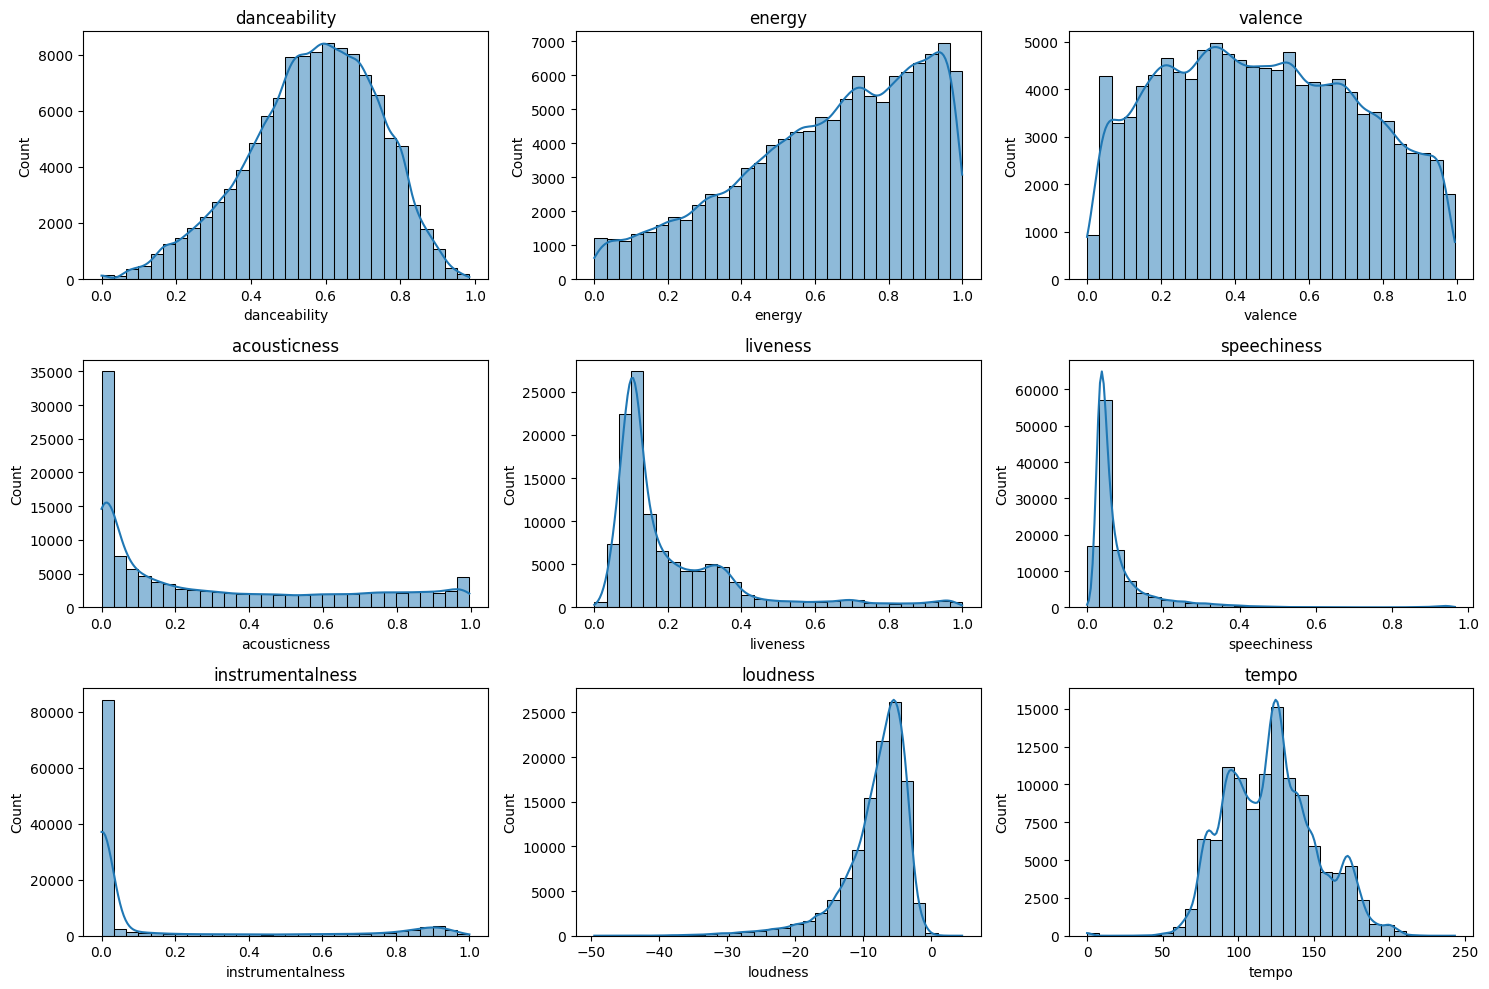

In [ ]:
# Histograms for each audio feature to inspect distributions
plt.figure(figsize=(15, 10))
for i, feat in enumerate(audio_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feat], bins=30, kde=True)
    plt.title(feat)
plt.tight_layout()
plt.show()

Key insights:
- Danceability, energy, and valence mostly range between 0.5 and 1.0, indicating the tracks are generally upbeat, energetic, and emotionally positive.
- Acousticness and instrumentalness are right-skewed, suggesting most songs include vocals and electronic elements rather than being purely acoustic or instrumental.
- Speechiness has a long-tailed distribution, with most tracks having little spoken content, but a small subset (e.g., rap or spoken word) showing high speechiness.

We will use a correlation heatmap to examine how these audio features interact with each other.

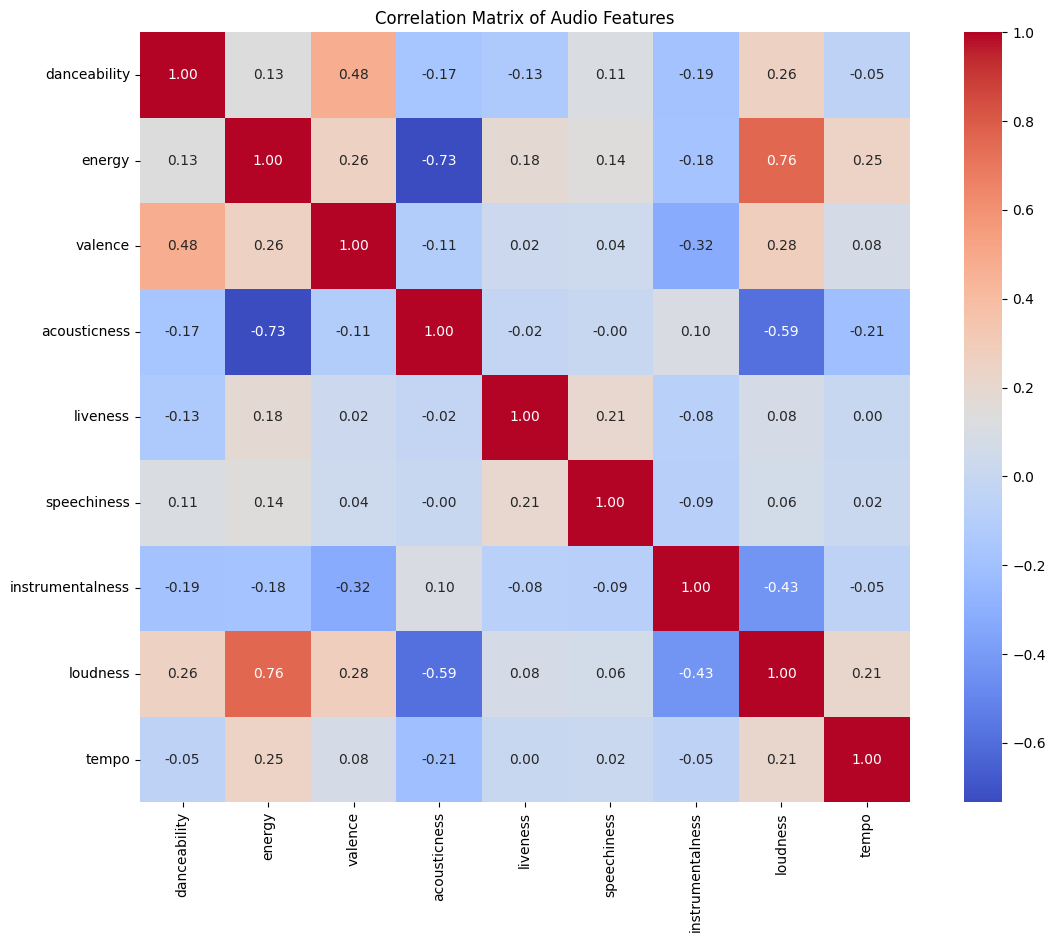

In [ ]:
# Correlation matrix heatmap
corr = df[audio_features].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Audio Features')
plt.show()

Key insights:
- Valence (happiness) is positively correlated with:
  - Danceability (0.48) – happy songs are more danceable.
  - Energy (0.26) and Loudness (0.28) – happy songs are louder and more energetic.
- Energy is strongly:
  - Positively correlated with Loudness (0.76) – energetic songs are loud.
  - Negatively correlated with Acousticness (-0.73) – energetic songs are less acoustic.
- Acousticness is negatively correlated with:
  - Energy (-0.73) and Loudness (-0.59) – acoustic songs are calmer and quieter
  - Danceability (-0.17) – less likely to be danceable.
- Instrumentalness negatively correlates with Valence (-0.32) and Loudness (-0.43), indicating that instrumental songs tend to be less emotionally positive (may evoke different moods or be more neutral).

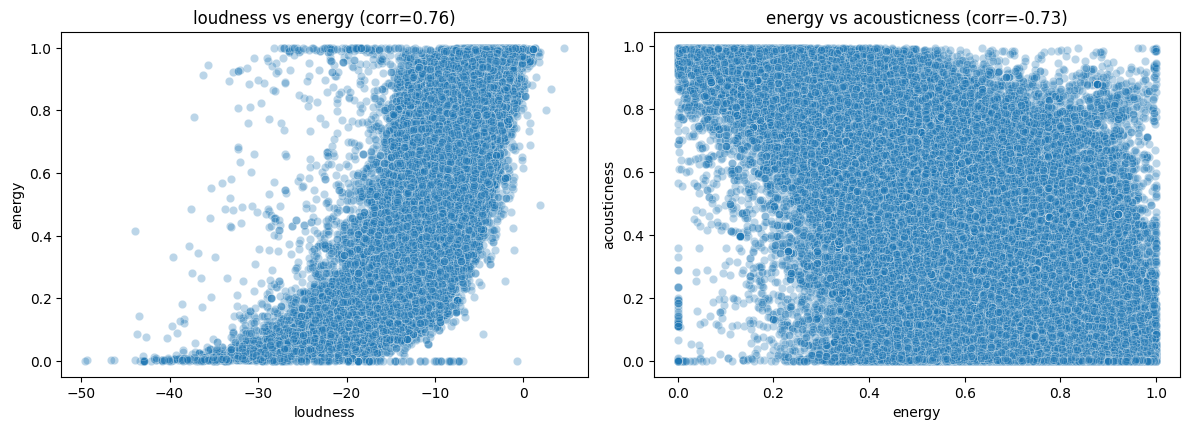

In [ ]:
# Scatter plots for highly correlated pairs (|corr| > 0.6)
high_corr = corr.abs().unstack().sort_values(ascending=False)
# filter self and duplicates
pairs = [(a,b) for (a,b),v in high_corr.items() if a != b and v>0.6]
seen=set()
pairs_unique=[]
for a,b in pairs:
    if (b,a) not in seen:
        pairs_unique.append((a,b))
        seen.add((a,b))
    if len(pairs_unique)>=4: break  # limit to first 4

plt.figure(figsize=(12, 8))
for idx,(a,b) in enumerate(pairs_unique,1):
    plt.subplot(2,2,idx)
    sns.scatterplot(x=df[a], y=df[b], alpha=0.3)
    plt.title(f'{a} vs {b} (corr={corr.loc[a,b]:.2f})')
plt.tight_layout()
plt.show()

We then confirmed the correlation by creating scatterplots (Figure 3) for feature pairs with |r| > 0.6. As observed, louder and more energetic songs tend to be less acoustic.

## 4. Algorithmic Thinking
**Objective:**
- Develop step-by-step computational processes to efficiently manipulate the dataset and apply unsupervised machine learning techniques (K-means clustering, Gaussian mixture models, and Fuzzy C-means) to cluster mood-based songs.
- Analyze users’ listening histories to identify their emotional listening profiles.
- Recommend personalized playlists that guide users from negative moods (sad or angry) toward more positive, calming states (happy or calm).





Combining our EDA with Panda et al.’s findings [(source)](https://www.researchgate.net/publication/370450676_Music_Mood_Prediction_Based_on_Spotify's_Audio_Features_Using_Logistic_Regression ), we selected three key audio features - valence, energy, and acousticness - as they are most relevant to emotion classification.

In [ ]:
features = df[['energy', 'acousticness','valence']]

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   energy        113999 non-null  float64
 1   acousticness  113999 non-null  float64
 2   valence       113999 non-null  float64
dtypes: float64(3)
memory usage: 3.5 MB


##### Data Preprocessing

In [ ]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2, random_state = 42)
X_pca = pca.fit_transform(X_scaled)

### 4.1 Mood-based Clustering of Songs

#### a. K-means Clustering

##### Train the model

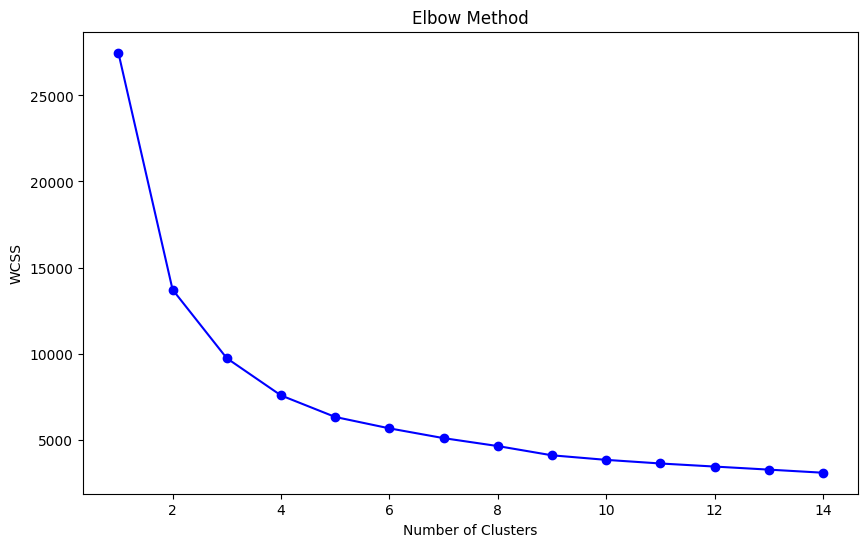

In [ ]:
# Elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, max_iter=100, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

We apply WCSS (Within-Cluster Sum of Squares) to identify the optimal number of clusters, which appears to be at 4 where the elbow occurs.

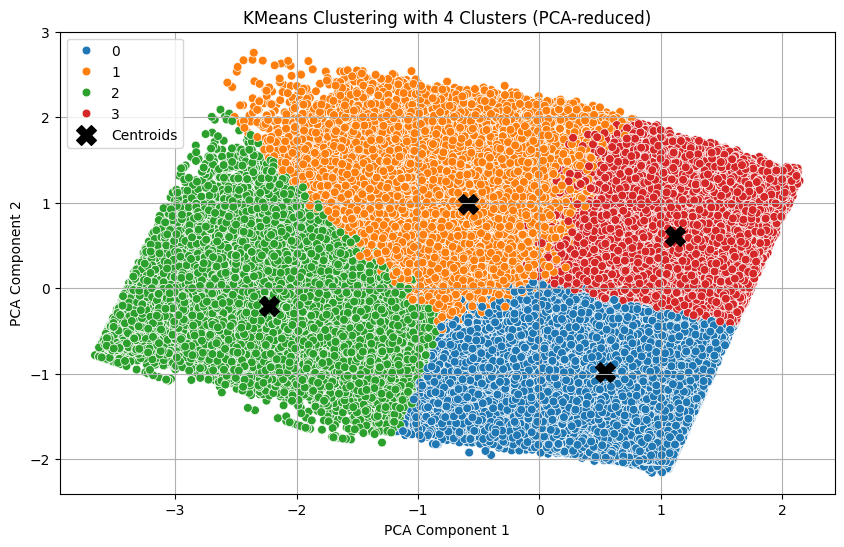

In [ ]:
# Fit KMeans with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, max_iter=300, random_state=42)
clusters = kmeans_4.fit_predict(X_scaled)
df['cluster'] = clusters

# Get cluster centers in original feature space and reduce to 2D
centers_2d = pca.transform(kmeans_4.cluster_centers_)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='tab10', legend='full', s=40)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, marker='X', label='Centroids')
plt.title('KMeans Clustering with 4 Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Show cluster centers for 4 clusters
print("Cluster Centers (4 Clusters):")
print(kmeans_4.cluster_centers_)

Cluster Centers (4 Clusters):
[[ 0.46974306 -0.68826245 -0.7582459 ]
 [-0.35055471  0.86005016  0.7186202 ]
 [-1.48539521  1.42712478 -0.87520184]
 [ 0.60487687 -0.62739497  0.93681906]]


Each cluster center represents a distinct mood profile, summarized as follows:

| Cluster | Energy   | Acousticness | Valence  | Mood Summary                 | **Mapped Mood** |
| ------- | -------- | ------------ | -------- | ---------------------------- | --------------- |
| 0       | High     | Low          | Low      | Intense, emotional, dark     | **Angry**       |
| 1       | Low-Med  | High         | High     | Relaxed, acoustic, cheerful  | **Calm**        |
| 2       | Very Low | Very High    | Very Low | Soft, acoustic, melancholic  | **Sad**         |
| 3       | High     | Low          | High     | Energetic, synthetic, joyful | **Happy**       |


##### Model Performance


In [ ]:
score = silhouette_score(X_pca, clusters)
print("Silhouette Score:", score)

Silhouette Score: 0.401502276559957


This falls in the moderate range (<0.5). It's acceptable, but not highly separated.

In [ ]:
score = davies_bouldin_score(X_pca, clusters)
print("Davies-Bouldin Score:", score)

Davies-Bouldin Score: 0.8388807150108226


A score of 0.84 is considered good, because it's below 1. This indicates that the clusters are relatively compact and distinct from each other.

> Overall, the results indicate that valence, energy, and acousticness can group songs by emotional tone fairly well, though some overlap between moods is natural. The model provides a reasonable foundation for building a music recommendation system that supports emotional transitions, even though further refinement or supervised validation may enhance accuracy.






#### b. Gaussian Mixture Models Clustering

##### Train the model

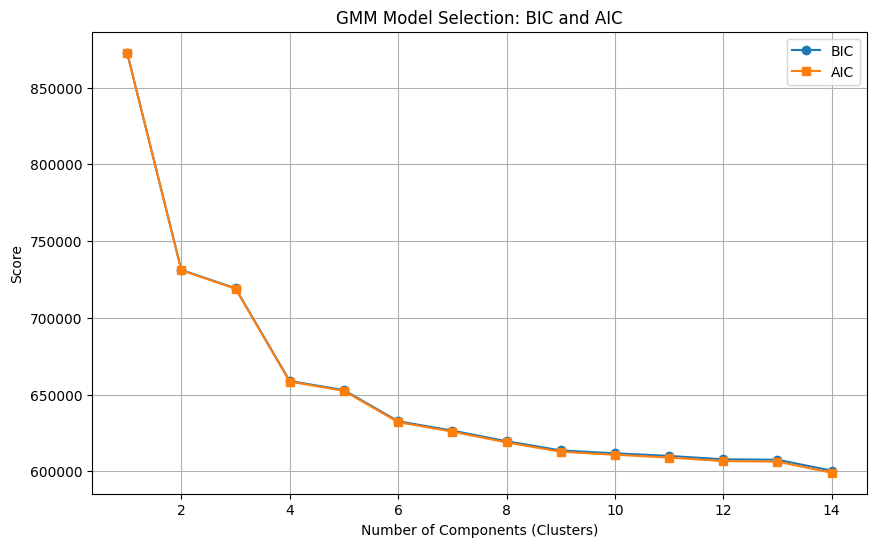

In [ ]:
bic_scores = []
aic_scores = []
n_components_range = range(1, 15)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

# Plot BIC and AIC
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='s')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('Score')
plt.title('GMM Model Selection: BIC and AIC')
plt.legend()
plt.grid(True)
plt.show()

We use BIC and AIC to determine the optimal number of clusters, which is found to be 4, where both scores are minimized.

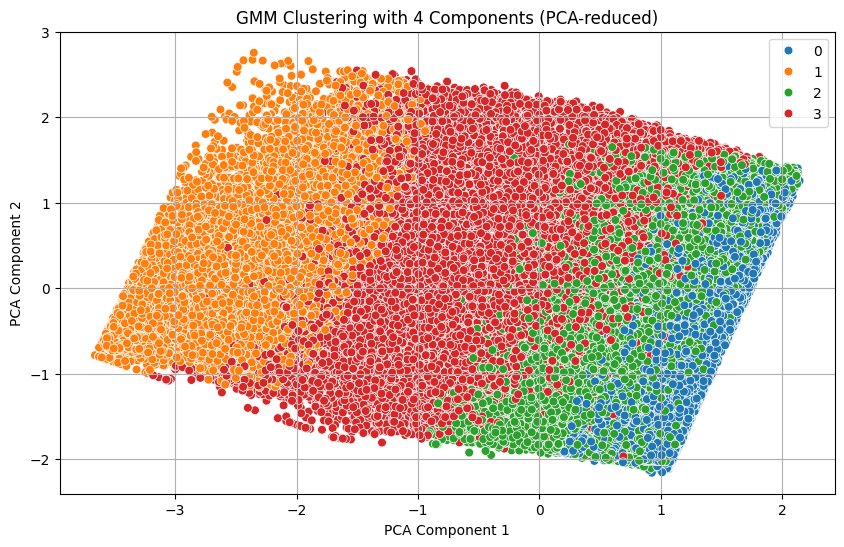

In [ ]:
# Fit GMM with 4 cluster
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
gmm_clusters = gmm.predict(X_scaled)

# Assign cluster labels to the DataFrame
df['gmm_cluster'] = gmm_clusters

# Visualize GMM Clusters in PCA-reduced space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_clusters, palette='tab10', legend='full', s=40)
plt.title('GMM Clustering with 4 Components (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#  Show GMM means
print("GMM Cluster Means:")
print(gmm.means_)

GMM Cluster Means:
[[ 0.97422087 -0.9415563  -0.26274758]
 [-1.59215991  1.710761   -0.56515562]
 [ 0.42612822 -0.78145525  0.15784037]
 [-0.14560179  0.33573763  0.20873975]]


Each cluster center represents a distinct mood profile, summarized as follows:

| Cluster | Energy   | Acousticness | Valence       | Mood Summary                  | **Mapped Mood** |
| ------- | -------- | ------------ | ------------- | ----------------------------- | --------------- |
| 0       | High     | Low          | Low           | Intense, synthetic, emotional | **Angry**       |
| 1       | Very Low | Very High    | Low           | Soft, acoustic, melancholic   | **Sad**         |
| 2       | Moderate | Low          | Slightly High | Energetic, upbeat, electronic | **Happy**       |
| 3       | Low      | Moderate     | Moderate      | Mellow, calm, balanced        | **Calm**        |



##### Model Performance

In [ ]:
# Show GMM probabilities
probs = gmm.predict_proba(X_scaled)
probs.max(axis=1)

array([0.86065123, 0.9892444 , 0.99874762, ..., 0.88990673, 0.99999998,
       0.82609995])

In [ ]:
# Calculate average confidence (mean of max probabilities)
mean_confidence = probs.max(axis=1).mean()
print(f"Average GMM cluster confidence: {mean_confidence:.4f}")

Average GMM cluster confidence: 0.9092


From a GMM perspective, a confidence of 0.9092 indicates that the fitted Gaussian components model the data effectively, with minimal ambiguity in cluster membership. Most points have a dominant likelihood under a single component, reflecting strong and distinct cluster structures.

In [ ]:
# Silhouette Score
score = silhouette_score(X_scaled, gmm_clusters)
print("Silhouette Score:", score)

Silhouette Score: 0.11017351852736545


A Silhouette Score of 0.11 means the clustering structure is weak but somewhat present.

In [ ]:
# Davies-Bouldin Score
score = davies_bouldin_score(X_scaled, gmm_clusters)
print("Davies-Bouldin Score:", score)

Davies-Bouldin Score: 2.053679113204019


A Davies-Bouldin Score of 2.05 indicates moderate to poor clustering quality, with clusters that are not well separated and likely have significant overlap.

#### c. Fuzzy C-means

##### Train the model

In [ ]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.8 MB/s eta 0:00:00


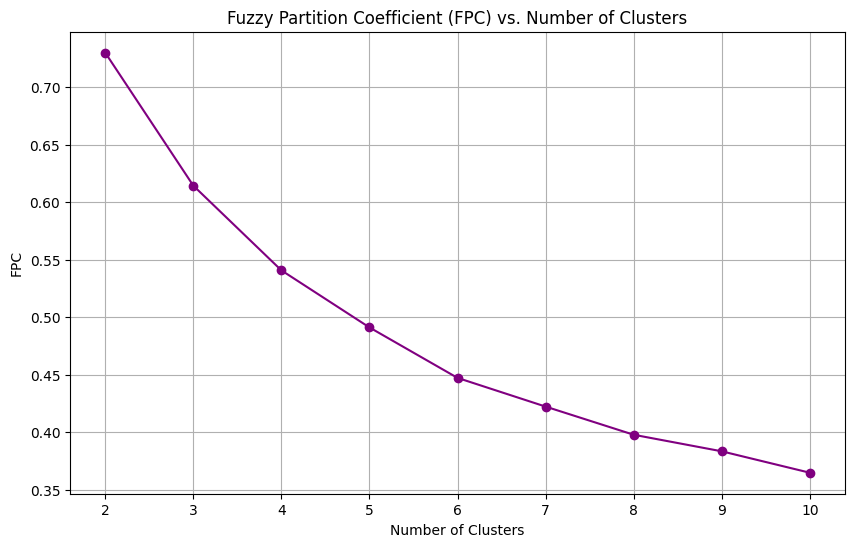

In [ ]:
import skfuzzy as fuzz
fpc_values = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_scaled.T, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None, seed=42
    )
    fpc_values.append(fpc)

# Plot FPC vs. number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, fpc_values, marker='o', linestyle='-', color='purple')
plt.title('Fuzzy Partition Coefficient (FPC) vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('FPC')
plt.grid(True)
plt.show()

FPC is highest at about 0.73 with 2 clusters and drops as the number of clusters grows. Still, considering business goals, choosing 4 clusters might make more sense even though the FPC is lower.

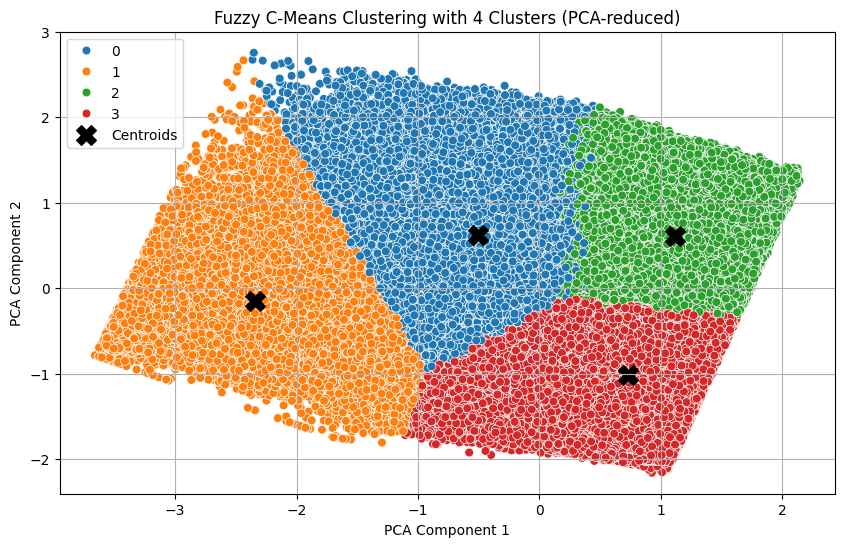

In [ ]:
# Fuzzy C-Means clustering
n_clusters = 4
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None, seed=42
)

# Assign each data point to the cluster with the highest membership
cluster_labels = np.argmax(u, axis=0)
df['fuzzy_cluster'] = cluster_labels

# Project cluster centers into 2D using PCA
centers_2d = pca.transform(cntr)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='tab10', legend='full', s=40)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, marker='X', label='Centroids')
plt.title('Fuzzy C-Means Clustering with 4 Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print cluster centers
print("Cluster Centers (4 Clusters, Fuzzy C-Means):")
print(cntr)

Cluster Centers (4 Clusters, Fuzzy C-Means):
[[-0.3534663   0.5924078   0.42268587]
 [-1.55563782  1.5347167  -0.8594505 ]
 [ 0.63135098 -0.6092562   0.93526093]
 [ 0.65632463 -0.7631558  -0.74425405]]


| **Cluster** | **Energy**            | **Valence**             | **Danceability**  | **Interpretation**                         | **Mapped Mood**     |
| ----------- | --------------------- | ----------------------- | ----------------- | ------------------------------------------ | ------------------- |
| **0**       | Low–Moderate | Moderately High  | Moderate | Mildly energetic and positive              | **Calm**      |
| **1**       | Very Low     | Very High       | Very Low  | Emotionally rich but low energy and rhythm | **Sad** |
| **2**       | High          | Low            | Very High | Intense, negative emotion, rhythmic        | **Angry**     |
| **3**       | High           | Very Low        | Very Low  | Intense and dark, low rhythmic feel        | **Angry**        |


##### Model Performance

In [ ]:
# Print Fuzzy Partition Coefficient (FPC)
print("Fuzzy Partition Coefficient (FPC):", fpc)

Fuzzy Partition Coefficient (FPC): 0.5407251737412923


An FPC of 0.54 indicates moderate cluster overlap, meaning the clusters are somewhat distinct but not sharply separated.

In [ ]:
score = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score:", score)

Silhouette Score: 0.3992387567522428


This falls in the moderate range (<0.5). It's acceptable, but not highly separated.

In [ ]:
score = davies_bouldin_score(X_pca, cluster_labels)
print("Davies-Bouldin Score:", score)

Davies-Bouldin Score: 0.8631067133647023


A Davies-Bouldin Score of 0.86 (<1) indicates fairly good cluster separation and compactness.

#### d. Model Evaluation

To evaluate clustering performance, we use Silhouette Score and Davies-Bouldin Score. A Silhouette Score above 0.3 suggests moderately well-defined clusters, while scores above 0.5 are considered good. For Davies-Bouldin Score, values below 1.0 indicate well-separated and compact clusters, with lower scores being better.

| Algorithm         | Silhouette Score ↑ | Davies-Bouldin Score ↓ |
| ----------------- | ------------------ | ---------------------- |
| **K-Means**       | **0.4015**         | **0.8389**             |
| **Fuzzy C-Means** | 0.3992             | 0.8631                 |
| **GMM**           | 0.1102             | 2.0537                 |

Among the three methods, K-Means performs the best overall with the highest Silhouette Score and lowest Davies-Bouldin Score, indicating the most distinct and well-separated clusters. Fuzzy C-Means is a close second, while GMM performs poorly in this context.

Thus, we choose K-Means as the most suitable clustering method for this task.

### 4.2 Analyze User History & Recommend Playlist

We created the cluster map based on the cluster result from KMeans, which describes 4 distinct mood profiles for the playlists, each determined by their average of selected features.

- Cluster 0: Angry – characterized by high energy, low acousticness, and low valence, producing an intense, emotional, and dark mood with driving beats and minimal acoustic elements.

- Cluster 1: Calm – characterized by low to medium energy, high acousticness, and high valence, forming a relaxed, acoustic, and cheerful mood.

- Cluster 2: Sad – featured very low energy, very high acousticness, and very low valence, representing a soft, acoustic, and melancholic mood.

- Cluster 3: Happy – characterized by high energy, low acousticness, and high valence, this cluster captures an energetic, synthetic, and joyful mood.

In [ ]:
import random
cluster_map = {
    0: {"mood":"Angry", "label":"Intense, emotional, dark",
        "persona":"The Firestorm",    "prompt":"Try something calmer?"},
    1: {"mood":"Calm",  "label":"Relaxed, acoustic, cheerful",
        "persona":"The Chill Wave",   "prompt":"Keep riding this good vibe!"},
    2: {"mood":"Sad",   "label":"Soft, acoustic, melancholic",
        "persona":"The Blue Horizon", "prompt":"Want a bit more brightness?"},
    3: {"mood":"Happy", "label":"Energetic, synthetic, joyful",
        "persona":"The Sunburst",     "prompt":"Keep that energy up!"}
}

We then created a function to analyze the mood distribution of a user’s playlist, given a list of playlist IDs.

It first selects tracks in the playlist using their indices (playlist_ids) then calculates the normalized frequency of tracks in each cluster using value_counts. If any cluster (0 to 3) has no tracks, it sets the frequency to 0 to ensure all clusters are represented. Finally, it returns a sorted mood distribution by cluster index.

In [ ]:
def mood_distribution(df, playlist_ids):
    sub = df.loc[playlist_ids]
    dist = sub['cluster'].value_counts(normalize=True)
    for c in range(4):
        if c not in dist:
            dist[c] = 0.0
    return dist.sort_index()

This function generates a personalized profile based on the user’s most listened-to mood cluster:

- It first identifies the dominant cluster by finding the cluster with the highest distribution in the playlist, then use the cluster_map to fetch mood, persona, label, and prompt details for this cluster.

- It also creates a “pie” dictionary representing the percentage of tracks from each mood present in the playlist. Its' final output returns a summary dictionary including the persona name, pie chart data, a tagline describing the listening habits, a gentle prompt to diversify, and the main mood which will has already been created earlier in the first function

In [ ]:
def generate_persona(dist):
    top = int(dist.idxmax())
    m = cluster_map[top]
    pie = { cluster_map[c]["mood"]: round(p*100)
            for c,p in dist.items() if p>0 }
    return {
        "name":     m["persona"],
        "pie":      pie,
        "tagline":  f"You've been listening to {m['label'].lower()} tracks this week.",
        "prompt":   m["prompt"],
        "main_mood":m["mood"]
    }

The next function aims to generate a mood-based playlist recommendation using two clusters:

- It first determines the user’s current mood distribution (mood_distribution). If no target_cluster is specified, it uses the uplift_map to choose a pre-defined “uplift” target cluster that complements the user’s dominant cluster (e.g., Angry → Calm).

- It then calculates the number of tracks to sample from the user’s dominant mood cluster (n1) and the target cluster (n2), based on the given ratio, then randomly samples tracks from both clusters to create a balanced, mood-shifting playlist.

- Finally, it returns the combined playlist of track indices along with the current and target clusters.

In [ ]:
def recommend_playlist(df, playlist_ids,
                       target_cluster=None,
                       n_tracks=20,
                       ratio=(0.6,0.4)):
    dist = mood_distribution(df, playlist_ids)
    user_cluster = int(dist.idxmax())
    if target_cluster is None:
        uplift_map = {0:1, 1:3, 2:1, 3:1}
        target_cluster = uplift_map[user_cluster]
    n1 = int(n_tracks * ratio[0])
    n2 = n_tracks - n1
    pool1 = df[df['cluster']==user_cluster].index.tolist()
    pool2 = df[df['cluster']==target_cluster].index.tolist()
    rec1 = random.sample(pool1, min(len(pool1), n1))
    rec2 = random.sample(pool2, min(len(pool2), n2))
    return rec1 + rec2, user_cluster, target_cluster

The next function is similar to mood_distribution, but instead of track indices, it uses track names:

- It first selects tracks by matching their names to the playlist_names list, then calculates and fills in missing clusters with zero, ensuring consistent cluster representation.

- The resulting normalized mood distribution is sorted and returned.

In [ ]:
def mood_distribution_by_name(df, playlist_names):
    sub = df[df['track_name'].isin(playlist_names)]
    dist = sub['cluster'].value_counts(normalize=True)
    for c in range(4):
        if c not in dist: dist[c] = 0.0
    return dist.sort_index()

The final function represent a variation of recommend_playlist that works with track names rather than IDs:

- It computes the user’s mood distribution using mood_distribution_by_name. If no target cluster is provided, it chooses a complementary cluster using the uplift_map.

- It calculates how many tracks to sample from the current and target clusters, following the desired ratio. It randomly samples track names instead of indices to create a balanced playlist recommendation.

- The function returns the final list of recommended track names along with the current and target clusters.


In [ ]:
def recommend_playlist_by_name(df, playlist_names,
                              target_cluster=None,
                              n_tracks=10,
                              ratio=(0.6,0.4)):
    dist = mood_distribution_by_name(df, playlist_names)
    user_cluster = int(dist.idxmax())
    if target_cluster is None:
        uplift_map = {0:1, 1:3, 2:1, 3:1}
        target_cluster = uplift_map[user_cluster]
    n1 = int(n_tracks * ratio[0])
    n2 = n_tracks - n1
    pool1 = df[df['cluster']==user_cluster]['track_name'].tolist()
    pool2 = df[df['cluster']==target_cluster]['track_name'].tolist()
    rec1 = random.sample(pool1, min(len(pool1), n1))
    rec2 = random.sample(pool2, min(len(pool2), n2))
    return rec1 + rec2, user_cluster, target_cluster

# Trial Use Case

**Trial Use Case for Positive & Calm mood**

We first initialize a list of track names representing the current user playlist to be analyzed. Then, for each track name, filter the main dataset to find the corresponding record, then collect the track’s name, cluster, and associated mood into a list. Finally, we print the current playlist with track details in a nicely formatted Markdown table for readability.

In [ ]:
current_names = ["Shape of You", "Someone Like You", "Happy", "Hallelujah"]

rows = []
for name in current_names:
    row = df[df['track_name'] == name].iloc[0]
    rows.append({
        "track_name": row['track_name'],
        "cluster":    row['cluster'],
        "mood":       cluster_map[row['cluster']]['mood']
    })

input_df = pd.DataFrame(rows)

# Print Markdown table:
print("=== Current User Playlist ===")
print(input_df.to_markdown(index=False, tablefmt="grid"))

=== Current User Playlist ===
+------------------+-----------+--------+
| track_name       |   cluster | mood   |
+==================+===========+========+
| Shape of You     |         1 | Calm   |
+------------------+-----------+--------+
| Someone Like You |         2 | Sad    |
+------------------+-----------+--------+
| Happy            |         1 | Calm   |
+------------------+-----------+--------+
| Hallelujah       |         2 | Sad    |
+------------------+-----------+--------+


Next, we calculate the distribution of moods represented by the current playlist tracks and create a persona summarizing the user’s music preferences derived from the mood distribution.

We also get a list of recommended tracks and related similarity metrics based on the current playlist for later recommendation.

In [ ]:
# Calculate recommended persona & playlist
dist2 = mood_distribution_by_name(df, current_names)
persona = generate_persona(dist2)
rec_names, uc, tc = recommend_playlist_by_name(df, current_names)

# Print Persona Card
persona_df = pd.DataFrame.from_dict(persona, orient='index', columns=['Value'])
persona_df.index.name = 'Attribute'
print("\n=== Persona Card ===")
print(persona_df.to_markdown(tablefmt="grid"))


=== Persona Card ===
+-------------+------------------------------------------------------------------------+
| Attribute   | Value                                                                  |
+=============+========================================================================+
| name        | The Blue Horizon                                                       |
+-------------+------------------------------------------------------------------------+
| pie         | {'Angry': 4, 'Calm': 14, 'Sad': 73, 'Happy': 8}                        |
+-------------+------------------------------------------------------------------------+
| tagline     | You've been listening to soft, acoustic, melancholic tracks this week. |
+-------------+------------------------------------------------------------------------+
| prompt      | Want a bit more brightness?                                            |
+-------------+------------------------------------------------------------------------+

For the recommended playlist, we then retrieve detailed info (track name, cluster, mood) for each recommended track from the dataset and convert info into a DataFrame. Finally, print the recommended playlist into a nicely formatted table

In [ ]:
import pandas as pd

# Example: Load your CSVs or dataframes
listening = pd.read_json("D:/StreamingHistory6.json")
songs = pd.read_csv("D:/Spotify_Song_Attributes.csv")

listening.columns

# Normalize for matching (optional but recommended)
for df in [listening, songs]:
    df['trackName'] = df['trackName'].str.strip().str.lower()
    df['artistName'] = df['artistName'].str.strip().str.lower()

# Perform INNER JOIN on trackName and artistName
merged_df = pd.merge(
    listening,
    songs,
    how='inner',
    on=['trackName', 'artistName']
)

# View or export result
print(merged_df.head())
merged_df.to_csv('listening_matched_with_songs.csv', index=False)

songs = songs.dropna()

#-------
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# Select relevant features
features = songs[['energy', 'acousticness', 'valence']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Fit KMeans
kmeans_4 = KMeans(n_clusters=4, n_init=10, max_iter=300, random_state=42)
songs['cluster'] = kmeans_4.fit_predict(features_scaled)

# View cluster centroids (denormalized)
centroids_scaled = kmeans_4.cluster_centers_
centroids = pd.DataFrame(scaler.inverse_transform(centroids_scaled), columns=['energy', 'acousticness', 'valence'])
centroids['cluster_id'] = centroids.index
print(centroids.sort_values(['valence', 'energy', 'acousticness'], ascending=[False, False, True]))


# Map cluster IDs to moods after inspecting centroids
cluster_to_mood = {
    0: 'happy',
    1: 'calm',
    2: 'angry',
    3: 'sad'
}

# Add mood labels
songs['mood'] = songs['cluster'].map(cluster_to_mood)

from sklearn.neighbors import NearestNeighbors
import numpy as np

# Count how many songs are in each mood
mood_counts = songs['mood'].value_counts()
major_mood = mood_counts.idxmax()
print(f"Major detected mood: {major_mood}")

# Define mood transition logic
mood_transition_map = {
    'angry': 'calm',
    'sad': 'happy',
    'happy': 'happy',
    'calm': 'calm'
}

# Set source and target moods
source_mood = major_mood
target_mood = mood_transition_map[major_mood]

print(f"Target mood transition: {source_mood} → {target_mood}")

# Get a vector representing the "angry" mood (e.g., average angry song)
source_vector = songs[songs['mood'] == source_mood][['energy', 'acousticness', 'valence']].mean().values.reshape(1, -1)
source_vector_scaled = scaler.transform(source_vector)

# Prepare target mood songs
target_songs = songs[songs['mood'] == target_mood]
target_features_scaled = scaler.transform(target_songs[['energy', 'acousticness', 'valence']])

# Fit KNN on target mood songs
knn = NearestNeighbors(n_neighbors=5)
knn.fit(target_features_scaled)

# Find nearest neighbors to angry vector in calm songs
distances, indices = knn.kneighbors(source_vector_scaled)

# Get recommended calm songs
recommended_songs = target_songs.iloc[indices[0]]
print("=========Your recommended playlist=======")
print((recommended_songs[['trackName', 'artistName', 'energy', 'acousticness', 'valence']]).to_markdown(index=False, tablefmt="grid"))


=== Recommended Playlist ===
+---------------------------------------------------------------------------------------------------------------+-----------+--------+
| track_name                                                                                                    |   cluster | mood   |
+===============================================================================================================+===========+========+
| Christmas Oratorio, BWV 248 / Part One - For The First Day Of Christmas: No. 1 Chorus: "Jauchzet, frohlocket" |         2 | Sad    |
+---------------------------------------------------------------------------------------------------------------+-----------+--------+
| On Borrowed Time                                                                                              |         2 | Sad    |
+---------------------------------------------------------------------------------------------------------------+-----------+--------+
| Departures 〜あなたにおくるアイの歌

In [ ]:
# TRIAL CASE WITH ANGRY AND SAD MOOD SONG
songs_0 = df[df['cluster']==0]['track_name'].unique()[:3].tolist()
songs_2 = df[df['cluster']==2]['track_name'].unique()[:2].tolist()
mixed_songs = songs_0 + songs_2

# Current User Playlist
rows = []
for name in mixed_songs:
    row = df[df['track_name']==name].iloc[0]
    rows.append({
        "track_name": row['track_name'],
        "cluster":    row['cluster'],
        "mood":       cluster_map[row['cluster']]['mood']
    })
input_df = pd.DataFrame(rows)
print("=== Current User Playlist (Mixed Angry/Sad) ===")
print(input_df.to_markdown(index=False, tablefmt="grid"))

# Calculate Persona card
dist_mix = mood_distribution_by_name(df, mixed_songs)
persona_mix = generate_persona(dist_mix)
rec_mix, uc_mix, tc_mix = recommend_playlist_by_name(
    df, mixed_songs, n_tracks=10, ratio=(0.6,0.4)
)

persona_df = pd.DataFrame.from_dict(persona_mix, orient='index', columns=['Value'])
persona_df.index.name = 'Attribute'
print("\n=== Persona Card (Mixed Playlist) ===")
print(persona_df.to_markdown(tablefmt="grid"))

# Recommended Playlist (10 tracks)
rows2 = []
for name in rec_mix:
    row = df[df['track_name']==name].iloc[0]
    rows2.append({
        "track_name": row['track_name'],
        "cluster":    row['cluster'],
        "mood":       cluster_map[row['cluster']]['mood']
    })
rec_df = pd.DataFrame(rows2)
print("\n=== Recommended Playlist for Mixed Mood ===")
print(rec_df.to_markdown(index=False, tablefmt="grid"))

=== Current User Playlist (Mixed Angry/Sad) ===
+----------------------------+-----------+--------+
| track_name                 |   cluster | mood   |
+============================+===========+========+
| To Begin Again             |         0 | Angry  |
+----------------------------+-----------+--------+
| Hunger                     |         0 | Angry  |
+----------------------------+-----------+--------+
| Hold On - Remix            |         0 | Angry  |
+----------------------------+-----------+--------+
| Ghost - Acoustic           |         2 | Sad    |
+----------------------------+-----------+--------+
| Can't Help Falling In Love |         2 | Sad    |
+----------------------------+-----------+--------+

=== Persona Card (Mixed Playlist) ===
+-------------+------------------------------------------------------------------------+
| Attribute   | Value                                                                  |
+=============+============================================